In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 4.0 MB/s 
     |████████████████████████████████| 258 kB 3.8 MB/s 
     |████████████████████████████████| 1.8 MB 55.0 MB/s 
     |████████████████████████████████| 103 kB 68.8 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
## Data split
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(data, 
                                                data['point_of_interest'], 
                                                data['point_of_interest'])):
    data.loc[val_idx, 'set'] = i

print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

valid_data = data[data['set'] == 0]
train_data = data[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Valid data: ')
analysis(valid_data)

train_poi = train_data['point_of_interest'].unique().tolist()
valid_poi = valid_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(valid_poi))

train_ids = train_data['id'].unique().tolist()
valid_ids = valid_data['id'].unique().tolist()

print(set(train_ids) & set(valid_ids))

tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['valid_ids'] = valid_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, valid_data
gc.collect()

data = data.set_index('id')
data = data.loc[tv_ids_d['train_ids']]
data = data.reset_index()

Num of train data: 1138812
1.0    569406
0.0    569406
Name: set, dtype: int64
Train data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369987
Mean num of unique poi: 1.5389892077289202
Valid data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369985
Mean num of unique poi: 1.5389975269267673
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tv_fit = tfidf.fit_transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data, CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/210 [00:00<?, ?it/s]

Start knn
Num of unique id: 569406
Num of train data: 13928057
Pos rate: 0.07242905453359359
                        id          match_id     kdist  kneighbors  \
2271553   E_fd464ba1740098  E_e9f184d83cae1e  0.007594         3.0   
2195812   E_db1da0832b0edb  E_43d12cd75a508f  0.003153         3.0   
6242880   E_f6b56f1f995bb8  E_559775ec266daa  0.002581        10.0   
9817306   E_3daed89cf926d8  E_7d12548cb02d23  0.001735        17.0   
11950281  E_92c117b8a31433  E_8f8f0ab8d049d3       NaN         NaN   

          kdist_country  kneighbors_country  label  
2271553        0.006657                 2.0      0  
2195812        0.003124                 3.0      0  
6242880        0.002541                10.0      0  
9817306        0.001725                17.0      0  
11950281       0.040197                12.0      0  


In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 569406
Unique id: 569406
IoU score: 0.9231233344021228


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%
development set - fold 3,92.76%,7.24%
validation set - fold 3,92.76%,7.24%
development set - fold 4,92.76%,7.24%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
train_data['kdist_diff'] = (train_data['kdist'] - train_data['kdist_country']) /\
                            train_data['kdist_country']
train_data['kneighbors_mean'] = train_data[['kneighbors', 'kneighbors_country']].mean(axis = 1)

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.num_split)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)

        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)

        file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [21]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      N_SPLITS=CFG.num_split, folds=train_data["fold"].values)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.0440953
[100]	valid_0's binary_logloss: 0.0423057
[150]	valid_0's binary_logloss: 0.0414409
[200]	valid_0's binary_logloss: 0.0408319
[250]	valid_0's binary_logloss: 0.0403797
[300]	valid_0's binary_logloss: 0.0399813
[350]	valid_0's binary_logloss: 0.0396457
[400]	valid_0's binary_logloss: 0.0392769
[450]	valid_0's binary_logloss: 0.038973
[500]	valid_0's binary_logloss: 0.0386924
[550]	valid_0's binary_logloss: 0.0384583
[600]	valid_0's binary_logloss: 0.0382465
[650]	valid_0's binary_logloss: 0.0380182
[700]	valid_0's binary_logloss: 0.0378259
[750]	valid_0's binary_logloss: 0.0376189
[800]	valid_0's binary_logloss: 0.0374366
[850]	valid_0's binary_logloss: 0.0373011
[900]	valid_0's binary_logloss: 0.0371323
[950]	valid_0's binary_logloss: 0.036997
[1000]	valid_0's binary_logloss: 0.0368482
[1050]	valid_0's binary_logloss: 0.0366841
[1100]	valid_0's binary_logloss: 0.0365268
[1150]	valid_0's binary_logloss: 0.0363662
[1200]	valid_0's bin

In [22]:
train_data["pred"] = oof[:, -1]

In [23]:
out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']

#Check Feature Importances

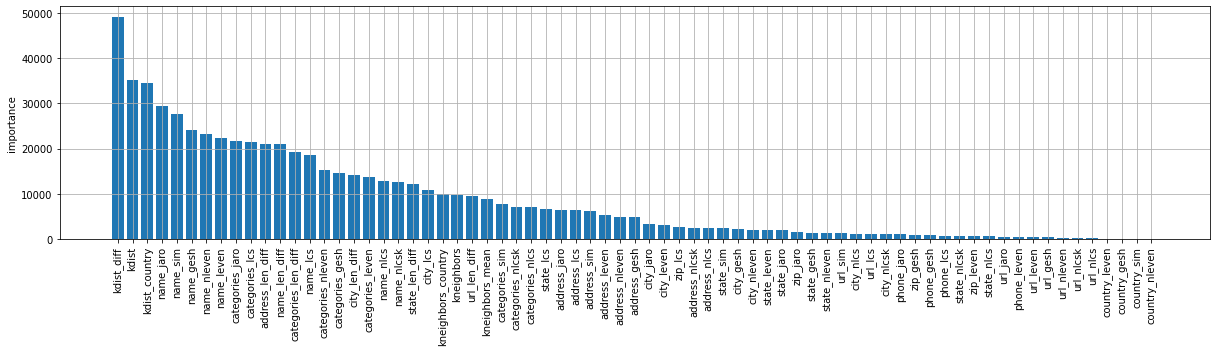

In [24]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [25]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 7.8 MB/s 
     |████████████████████████████████| 210 kB 61.9 MB/s 
     |████████████████████████████████| 78 kB 5.4 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 112 kB 78.0 MB/s 
     |████████████████████████████████| 146 kB 65.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=87d4b1c3a5282484515ed61fc4b2f889650d5f4fd4a2f98cc778caced291d911
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [26]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [28]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = train_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, train_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-22 05:17:57,393] A new study created in memory with name: no-name-76f367ee-82c2-4971-8a6b-91a9b881eaa0
[I 2022-05-22 05:18:18,460] Trial 0 finished with value: 0.879731969630578 and parameters: {'threshold': 0.6864775576650678}. Best is trial 0 with value: 0.879731969630578.


CV: 0.879732


[I 2022-05-22 05:18:39,742] Trial 1 finished with value: 0.756569697558736 and parameters: {'threshold': 0.028845911239477218}. Best is trial 0 with value: 0.879731969630578.


CV: 0.756570


[I 2022-05-22 05:18:59,457] Trial 2 finished with value: 0.8532779146911648 and parameters: {'threshold': 0.9136788756693213}. Best is trial 0 with value: 0.879731969630578.


CV: 0.853278


[I 2022-05-22 05:19:19,549] Trial 3 finished with value: 0.8786530649772439 and parameters: {'threshold': 0.7140042988409888}. Best is trial 0 with value: 0.879731969630578.


CV: 0.878653


[I 2022-05-22 05:19:38,836] Trial 4 finished with value: 0.8813744093753465 and parameters: {'threshold': 0.6098598094794925}. Best is trial 4 with value: 0.8813744093753465.


CV: 0.881374


[I 2022-05-22 05:19:59,056] Trial 5 finished with value: 0.8813917922069107 and parameters: {'threshold': 0.6072472003406384}. Best is trial 5 with value: 0.8813917922069107.


CV: 0.881392


[I 2022-05-22 05:20:19,951] Trial 6 finished with value: 0.8551717037169054 and parameters: {'threshold': 0.1878255200939396}. Best is trial 5 with value: 0.8813917922069107.


CV: 0.855172


[I 2022-05-22 05:20:39,230] Trial 7 finished with value: 0.8790156993214562 and parameters: {'threshold': 0.7058671315763948}. Best is trial 5 with value: 0.8813917922069107.


CV: 0.879016


[I 2022-05-22 05:20:59,344] Trial 8 finished with value: 0.8784093785575239 and parameters: {'threshold': 0.7195101461214777}. Best is trial 5 with value: 0.8813917922069107.


CV: 0.878409


[I 2022-05-22 05:21:19,650] Trial 9 finished with value: 0.8814900437694118 and parameters: {'threshold': 0.5955543701829423}. Best is trial 9 with value: 0.8814900437694118.


CV: 0.881490


[I 2022-05-22 05:21:39,302] Trial 10 finished with value: 0.8760294611822277 and parameters: {'threshold': 0.3715859913887108}. Best is trial 9 with value: 0.8814900437694118.


CV: 0.876029


[I 2022-05-22 05:21:59,836] Trial 11 finished with value: 0.8787238169135738 and parameters: {'threshold': 0.42998429127527144}. Best is trial 9 with value: 0.8814900437694118.


CV: 0.878724


[I 2022-05-22 05:22:18,170] Trial 12 finished with value: 0.7976655473909663 and parameters: {'threshold': 0.9881743084505539}. Best is trial 9 with value: 0.8814900437694118.


CV: 0.797666


[I 2022-05-22 05:22:37,536] Trial 13 finished with value: 0.8813080735831489 and parameters: {'threshold': 0.5411820349028068}. Best is trial 9 with value: 0.8814900437694118.


CV: 0.881308


[I 2022-05-22 05:22:58,020] Trial 14 finished with value: 0.8714717504335493 and parameters: {'threshold': 0.30779391041037674}. Best is trial 9 with value: 0.8814900437694118.


CV: 0.871472


[I 2022-05-22 05:23:17,620] Trial 15 finished with value: 0.8677585907368917 and parameters: {'threshold': 0.8435963121373503}. Best is trial 9 with value: 0.8814900437694118.


CV: 0.867759


[I 2022-05-22 05:23:36,514] Trial 16 finished with value: 0.8807196110549711 and parameters: {'threshold': 0.4980730366835243}. Best is trial 9 with value: 0.8814900437694118.


CV: 0.880720


[I 2022-05-22 05:23:56,848] Trial 17 finished with value: 0.8663851653600155 and parameters: {'threshold': 0.2593656930895445}. Best is trial 9 with value: 0.8814900437694118.


CV: 0.866385


[I 2022-05-22 05:24:15,493] Trial 18 finished with value: 0.8719715975728778 and parameters: {'threshold': 0.809418411244855}. Best is trial 9 with value: 0.8814900437694118.


CV: 0.871972


[I 2022-05-22 05:24:35,219] Trial 19 finished with value: 0.8815484642189582 and parameters: {'threshold': 0.5687263914220871}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.881548


[I 2022-05-22 05:24:54,317] Trial 20 finished with value: 0.879875574009334 and parameters: {'threshold': 0.46424391203268084}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.879876


[I 2022-05-22 05:25:14,393] Trial 21 finished with value: 0.881529526780628 and parameters: {'threshold': 0.5877645405507068}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.881530


[I 2022-05-22 05:25:34,284] Trial 22 finished with value: 0.8814681818219684 and parameters: {'threshold': 0.597393848198869}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.881468


[I 2022-05-22 05:25:53,544] Trial 23 finished with value: 0.881363280866716 and parameters: {'threshold': 0.5446026618780292}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.881363


[I 2022-05-22 05:26:14,030] Trial 24 finished with value: 0.8777237862970885 and parameters: {'threshold': 0.40901250178516874}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.877724


[I 2022-05-22 05:26:33,068] Trial 25 finished with value: 0.8733747622371492 and parameters: {'threshold': 0.7945702156181409}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.873375


[I 2022-05-22 05:26:53,233] Trial 26 finished with value: 0.8812314779065965 and parameters: {'threshold': 0.6197801174917335}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.881231


[I 2022-05-22 05:27:13,804] Trial 27 finished with value: 0.8750036416080389 and parameters: {'threshold': 0.3558337585371688}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.875004


[I 2022-05-22 05:27:33,218] Trial 28 finished with value: 0.8812150159341114 and parameters: {'threshold': 0.5322927696743845}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.881215


[I 2022-05-22 05:27:52,325] Trial 29 finished with value: 0.88060226404286 and parameters: {'threshold': 0.6566819098969674}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.880602


[I 2022-05-22 05:28:13,149] Trial 30 finished with value: 0.851978569081593 and parameters: {'threshold': 0.17289166494432756}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.851979


[I 2022-05-22 05:28:33,385] Trial 31 finished with value: 0.8815423352532692 and parameters: {'threshold': 0.570614721402081}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.881542


[I 2022-05-22 05:28:52,649] Trial 32 finished with value: 0.8805009151591041 and parameters: {'threshold': 0.4876560133525108}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.880501


[I 2022-05-22 05:29:12,737] Trial 33 finished with value: 0.8772604556939079 and parameters: {'threshold': 0.7407548579398837}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.877260


[I 2022-05-22 05:29:31,700] Trial 34 finished with value: 0.8805843805385479 and parameters: {'threshold': 0.6570751731885244}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.880584


[I 2022-05-22 05:29:51,717] Trial 35 finished with value: 0.8815253893920839 and parameters: {'threshold': 0.5670192548435551}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.881525


[I 2022-05-22 05:30:11,973] Trial 36 finished with value: 0.8815116689945421 and parameters: {'threshold': 0.5659211138430178}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.881512


[I 2022-05-22 05:30:32,037] Trial 37 finished with value: 0.878642487139839 and parameters: {'threshold': 0.42863395174929947}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.878642


[I 2022-05-22 05:30:52,406] Trial 38 finished with value: 0.8760870180860644 and parameters: {'threshold': 0.7594603172031246}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.876087


[I 2022-05-22 05:31:11,486] Trial 39 finished with value: 0.8806703863803034 and parameters: {'threshold': 0.6515683338702387}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.880670


[I 2022-05-22 05:31:31,507] Trial 40 finished with value: 0.8800913179999877 and parameters: {'threshold': 0.6734290310680697}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.880091


[I 2022-05-22 05:31:50,752] Trial 41 finished with value: 0.8815059438750812 and parameters: {'threshold': 0.563642669975743}. Best is trial 19 with value: 0.8815484642189582.


CV: 0.881506


[I 2022-05-22 05:32:10,805] Trial 42 finished with value: 0.881595406809883 and parameters: {'threshold': 0.5775658164424807}. Best is trial 42 with value: 0.881595406809883.


CV: 0.881595


[I 2022-05-22 05:32:31,053] Trial 43 finished with value: 0.880037235873874 and parameters: {'threshold': 0.46967683109334}. Best is trial 42 with value: 0.881595406809883.


CV: 0.880037


[I 2022-05-22 05:32:50,195] Trial 44 finished with value: 0.8812617831808394 and parameters: {'threshold': 0.6166475994113036}. Best is trial 42 with value: 0.881595406809883.


CV: 0.881262


[I 2022-05-22 05:33:10,235] Trial 45 finished with value: 0.8791854748144072 and parameters: {'threshold': 0.70103471407199}. Best is trial 42 with value: 0.881595406809883.


CV: 0.879185


[I 2022-05-22 05:33:30,928] Trial 46 finished with value: 0.7697796352124431 and parameters: {'threshold': 0.03541411900738817}. Best is trial 42 with value: 0.881595406809883.


CV: 0.769780


[I 2022-05-22 05:33:51,198] Trial 47 finished with value: 0.8807228294081922 and parameters: {'threshold': 0.49815308124960334}. Best is trial 42 with value: 0.881595406809883.


CV: 0.880723


[I 2022-05-22 05:34:10,461] Trial 48 finished with value: 0.8815582208528557 and parameters: {'threshold': 0.5864799094946831}. Best is trial 42 with value: 0.881595406809883.


CV: 0.881558


[I 2022-05-22 05:34:30,810] Trial 49 finished with value: 0.8770400122792849 and parameters: {'threshold': 0.3918064912256385}. Best is trial 42 with value: 0.881595406809883.


CV: 0.877040


[I 2022-05-22 05:34:50,526] Trial 50 finished with value: 0.8605074479537328 and parameters: {'threshold': 0.8858897290477168}. Best is trial 42 with value: 0.881595406809883.


CV: 0.860507


[I 2022-05-22 05:35:10,835] Trial 51 finished with value: 0.8811995573204073 and parameters: {'threshold': 0.5305377102346523}. Best is trial 42 with value: 0.881595406809883.


CV: 0.881200


[I 2022-05-22 05:35:30,039] Trial 52 finished with value: 0.881495637951811 and parameters: {'threshold': 0.5956645212173498}. Best is trial 42 with value: 0.881595406809883.


CV: 0.881496


[I 2022-05-22 05:35:49,278] Trial 53 finished with value: 0.881506153902098 and parameters: {'threshold': 0.5636768529067171}. Best is trial 42 with value: 0.881595406809883.


CV: 0.881506


[I 2022-05-22 05:36:09,517] Trial 54 finished with value: 0.8796078184114136 and parameters: {'threshold': 0.45560380191207656}. Best is trial 42 with value: 0.881595406809883.


CV: 0.879608


[I 2022-05-22 05:36:29,734] Trial 55 finished with value: 0.8808885329762344 and parameters: {'threshold': 0.5078629963357473}. Best is trial 42 with value: 0.881595406809883.


CV: 0.880889


[I 2022-05-22 05:36:48,760] Trial 56 finished with value: 0.8789714406697715 and parameters: {'threshold': 0.7072129030788945}. Best is trial 42 with value: 0.881595406809883.


CV: 0.878971


[I 2022-05-22 05:37:08,804] Trial 57 finished with value: 0.8810482457396899 and parameters: {'threshold': 0.6312478021013603}. Best is trial 42 with value: 0.881595406809883.


CV: 0.881048


[I 2022-05-22 05:37:27,928] Trial 58 finished with value: 0.8815344966668621 and parameters: {'threshold': 0.5878747767092248}. Best is trial 42 with value: 0.881595406809883.


CV: 0.881534


[I 2022-05-22 05:37:47,916] Trial 59 finished with value: 0.8771060357360125 and parameters: {'threshold': 0.7435571405102577}. Best is trial 42 with value: 0.881595406809883.


CV: 0.877106


[I 2022-05-22 05:38:07,010] Trial 60 finished with value: 0.8799283574418413 and parameters: {'threshold': 0.6800617485685191}. Best is trial 42 with value: 0.881595406809883.


CV: 0.879928


[I 2022-05-22 05:38:27,107] Trial 61 finished with value: 0.881597521991731 and parameters: {'threshold': 0.5816453465252149}. Best is trial 61 with value: 0.881597521991731.


CV: 0.881598


[I 2022-05-22 05:38:50,324] Trial 62 finished with value: 0.8815291365103776 and parameters: {'threshold': 0.5877679271711759}. Best is trial 61 with value: 0.881597521991731.


CV: 0.881529


[I 2022-05-22 05:39:09,806] Trial 63 finished with value: 0.8810151399045418 and parameters: {'threshold': 0.6328499292550136}. Best is trial 61 with value: 0.881597521991731.


CV: 0.881015


[I 2022-05-22 05:39:29,094] Trial 64 finished with value: 0.8811129918802637 and parameters: {'threshold': 0.5236150175387312}. Best is trial 61 with value: 0.881597521991731.


CV: 0.881113


[I 2022-05-22 05:39:49,187] Trial 65 finished with value: 0.8815162411278242 and parameters: {'threshold': 0.5932374628736132}. Best is trial 61 with value: 0.881597521991731.


CV: 0.881516


[I 2022-05-22 05:40:09,472] Trial 66 finished with value: 0.880090432416165 and parameters: {'threshold': 0.4712811785196183}. Best is trial 61 with value: 0.881597521991731.


CV: 0.880090


[I 2022-05-22 05:40:28,749] Trial 67 finished with value: 0.881254476716627 and parameters: {'threshold': 0.5362194363175639}. Best is trial 61 with value: 0.881597521991731.


CV: 0.881254


[I 2022-05-22 05:40:49,082] Trial 68 finished with value: 0.8789334370494287 and parameters: {'threshold': 0.4350177986036511}. Best is trial 61 with value: 0.881597521991731.


CV: 0.878933


[I 2022-05-22 05:41:08,217] Trial 69 finished with value: 0.8807531066124309 and parameters: {'threshold': 0.6452480988673749}. Best is trial 61 with value: 0.881597521991731.


CV: 0.880753


[I 2022-05-22 05:41:28,512] Trial 70 finished with value: 0.875140443411279 and parameters: {'threshold': 0.35741437957546085}. Best is trial 61 with value: 0.881597521991731.


CV: 0.875140


[I 2022-05-22 05:41:48,643] Trial 71 finished with value: 0.8815562094321743 and parameters: {'threshold': 0.585761878882045}. Best is trial 61 with value: 0.881597521991731.


CV: 0.881556


[I 2022-05-22 05:42:07,842] Trial 72 finished with value: 0.881590594195589 and parameters: {'threshold': 0.578492380753248}. Best is trial 61 with value: 0.881597521991731.


CV: 0.881591


[I 2022-05-22 05:42:27,925] Trial 73 finished with value: 0.8814985326030557 and parameters: {'threshold': 0.5614101250696014}. Best is trial 61 with value: 0.881597521991731.


CV: 0.881499


[I 2022-05-22 05:42:47,837] Trial 74 finished with value: 0.8799599167819371 and parameters: {'threshold': 0.6783257469147398}. Best is trial 61 with value: 0.881597521991731.


CV: 0.879960


[I 2022-05-22 05:43:07,862] Trial 75 finished with value: 0.8813104019548923 and parameters: {'threshold': 0.6131071309054906}. Best is trial 61 with value: 0.881597521991731.


CV: 0.881310


[I 2022-05-22 05:43:28,049] Trial 76 finished with value: 0.8806925952857528 and parameters: {'threshold': 0.4972906904672386}. Best is trial 61 with value: 0.881597521991731.


CV: 0.880693


[I 2022-05-22 05:43:47,226] Trial 77 finished with value: 0.8815942092344818 and parameters: {'threshold': 0.5786493826150877}. Best is trial 61 with value: 0.881597521991731.


CV: 0.881594


[I 2022-05-22 05:44:07,297] Trial 78 finished with value: 0.8810381602331547 and parameters: {'threshold': 0.5179092406203704}. Best is trial 61 with value: 0.881597521991731.


CV: 0.881038


[I 2022-05-22 05:44:26,572] Trial 79 finished with value: 0.8814627637801239 and parameters: {'threshold': 0.5512073200141592}. Best is trial 61 with value: 0.881597521991731.


CV: 0.881463


[I 2022-05-22 05:44:46,376] Trial 80 finished with value: 0.8735348334358596 and parameters: {'threshold': 0.7923005114409118}. Best is trial 61 with value: 0.881597521991731.


CV: 0.873535


[I 2022-05-22 05:45:06,555] Trial 81 finished with value: 0.8816053109775113 and parameters: {'threshold': 0.582232125083615}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.881605


[I 2022-05-22 05:45:25,721] Trial 82 finished with value: 0.8812488997119756 and parameters: {'threshold': 0.618351038755984}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.881249


[I 2022-05-22 05:45:45,843] Trial 83 finished with value: 0.8805999712051386 and parameters: {'threshold': 0.6566341873851317}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.880600


[I 2022-05-22 05:46:05,078] Trial 84 finished with value: 0.8815451176345769 and parameters: {'threshold': 0.5692196902973383}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.881545


[I 2022-05-22 05:46:25,293] Trial 85 finished with value: 0.8813125763261633 and parameters: {'threshold': 0.5408273976438609}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.881313


[I 2022-05-22 05:46:44,505] Trial 86 finished with value: 0.881385634402951 and parameters: {'threshold': 0.6096781562897702}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.881386


[I 2022-05-22 05:47:04,659] Trial 87 finished with value: 0.881594330438117 and parameters: {'threshold': 0.5781706553379523}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.881594


[I 2022-05-22 05:47:23,748] Trial 88 finished with value: 0.8783368994967181 and parameters: {'threshold': 0.7210030721817908}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.878337


[I 2022-05-22 05:47:42,863] Trial 89 finished with value: 0.880880069371157 and parameters: {'threshold': 0.6391815731067266}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.880880


[I 2022-05-22 05:48:02,956] Trial 90 finished with value: 0.8803688747912747 and parameters: {'threshold': 0.48321703718506137}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.880369


[I 2022-05-22 05:48:22,949] Trial 91 finished with value: 0.8815939914119085 and parameters: {'threshold': 0.5761005151018402}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.881594


[I 2022-05-22 05:48:41,995] Trial 92 finished with value: 0.8815802442607271 and parameters: {'threshold': 0.583433972113215}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.881580


[I 2022-05-22 05:49:02,015] Trial 93 finished with value: 0.8815971590869575 and parameters: {'threshold': 0.582876893080722}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.881597


[I 2022-05-22 05:49:22,096] Trial 94 finished with value: 0.8809183753810356 and parameters: {'threshold': 0.5087465139179551}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.880918


[I 2022-05-22 05:49:41,140] Trial 95 finished with value: 0.881396356447508 and parameters: {'threshold': 0.5476688859943522}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.881396


[I 2022-05-22 05:50:01,113] Trial 96 finished with value: 0.8804354595969133 and parameters: {'threshold': 0.6625172549385446}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.880435


[I 2022-05-22 05:50:20,100] Trial 97 finished with value: 0.8794831071482265 and parameters: {'threshold': 0.6931042783168386}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.879483


[I 2022-05-22 05:50:39,900] Trial 98 finished with value: 0.8811163488286675 and parameters: {'threshold': 0.6269830015078868}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.881116


[I 2022-05-22 05:51:00,010] Trial 99 finished with value: 0.8814178604104916 and parameters: {'threshold': 0.6024652365954005}. Best is trial 81 with value: 0.8816053109775113.


CV: 0.881418


In [29]:
threshold = study.best_params['threshold']
threshold

0.582232125083615

In [30]:
study.best_value

0.8816053109775113

In [31]:
train_pred_df = train_data[train_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, train_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.881605
